In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.set_printoptions(precision=3)

## Section 3.2: Generates the classes

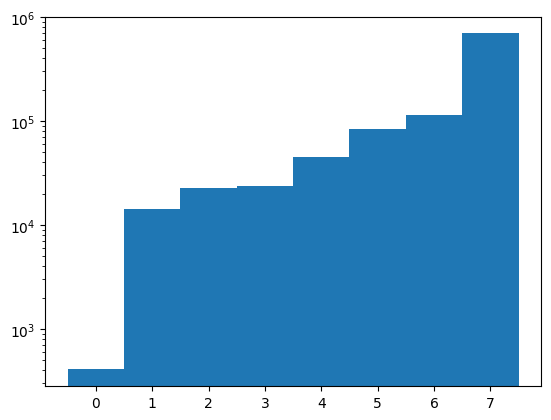

In [45]:
# These are important
b = 6
M = 8

u = np.random.uniform(0,1,M)*b
P = np.exp(np.log(b)*u)
P = np.sort(P/np.sum(P))

values = plt.hist(np.random.choice(M, 10**b, p=P), bins=[-0.5 + x for x in range(M+1)])
plt.yscale('log')
plt.show()

## Defines the conditional probability matrix class

In [46]:
# Generates the CPMs
class CPM:
    def __init__(self, type: str, dimensions: int, freq: np.ndarray, additional_params):
        '''
        This object defines the mock classifiers truth table.\n
        The parameters are:\n
        type: str, defines the mock classifier type\n
            the options are: ['perfect',
                              'noisy',
                              'tunnel',
                              'subs',
                              'mutually_subs',
                              'cruise']
        dimensions: int, defines the number of classes given\n
        freq: np.ndarray, the frequency of each class\n
        additional_params: some types may require additional parameters\n
            noisy: noise (int)\n
            tunnel: (focus_class)\n
            subs: (true_class, coppied_classes*, noise)\n
            mutuallysubs: [joined_classes*, noise]\n
            cruise: relevant (int)\n
            class = {0,1,...,dimension-1}
        '''
        self.type = type
        self.dimensions = dimensions
        self.freq = freq
        self.additional_params = additional_params

        self.CPM = np.zeros((dimensions, dimensions))
        self.generate_CPM()

    def generate_CPM(self):
        '''
        This function generates the CPM according to the type\n\n
        if mixandmatch = True, then it won't change the self.CPM,\n
            but will return a generated CPM instead.
        '''
        # Generates the perfect CPM
        if self.type == 'perfect':
            self.CPM = np.eye(self.dimensions)

        # Generates the noisy CPM
        elif self.type == 'noisy':
            noise = self.additional_params
            self.CPM = (np.eye(self.dimensions)*noise + np.ones((self.dimensions, self.dimensions))/self.dimensions)/(1+noise)

        # Generates the tunnel vision CPM
        elif self.type == 'tunnel':
            focus_index = self.additional_params
            self.CPM = np.zeros((self.dimensions, self.dimensions))
            for i in range(self.dimensions):
                if i == focus_index:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0 if j == focus_index else 0.0
                else:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0/self.dimensions if j != focus_index else 0.0

        # Generates the sbsummed type
        elif self.type == 'subs':
            true_index = self.additional_params[0]
            copy_classes = self.additional_params[0:-1]
            noise = self.additional_params[-1]
            self.CPM = np.zeros((self.dimensions, self.dimensions))
            for i in range(self.dimensions):
                if i in copy_classes:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0 if j == true_index else 0.0
                else:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0 if j == i else 0.0
            # Now we just add noise as before
            self.CPM = (self.CPM*noise + np.ones((self.dimensions, self.dimensions))/self.dimensions)/(1+noise)

        # Generates the mutually subsummed type
        elif self.type == 'mutuallysubs':
            copy_classes = self.additional_params[0:-1]
            normalising_factor = len(copy_classes)
            noise = self.additional_params[-1]
            self.CPM = np.zeros((self.dimensions, self.dimensions))
            for i in range(self.dimensions):
                if i in copy_classes:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0/normalising_factor if j in copy_classes else 0.0
                else:
                    for j in range(self.dimensions):
                        self.CPM[i][j] = 1.0 if j == i else 0.0
            # Now we just add noise as before
            self.CPM = (self.CPM*noise + np.ones((self.dimensions, self.dimensions))/self.dimensions)/(1+noise)

         # Generates the cruise control type
        elif self.type == 'cruise':
            noise = self.additional_params[1]
            relevant = self.additional_params[0]
            self.CPM = np.zeros((self.dimensions, self.dimensions))
            for i in range(self.dimensions):
                self.CPM[i][relevant] = 1.0
            # Now we just add noise as before
            self.CPM = (self.CPM*noise + np.ones((self.dimensions, self.dimensions))/self.dimensions)/(1+noise)

        # The type doesnt exist
        else:
            raise ValueError(f'The type: "{self.type}" is not defined')

        # Makes sure there aren't zeros
        for i in range(self.dimensions):
            for j in range(self.dimensions):
                self.CPM[i,j] = np.min((1.0e-6, np.min(self.freq)*0.1)) if self.CPM[i,j] == 0.0 else self.CPM[i,j]

    def add_to_cpm(self, add_CPM):
        '''
        Adds a CPM to the current CPM
        '''
        self.CPM = np.add(self.CPM, add_CPM.CPM)

    def normalize_cpm(self):
        '''
        Normalizes the CPM so that each row sums to 1
        '''
        for i in range(self.dimensions):
            self.CPM[i] = self.CPM[i]/np.sum(self.CPM[i])

    def dirichlet_sample(self, true_class: int, delta=0.01, size=1):
        '''
        Draws a dirichlet sample from a row to form \n
        a sample of CPMs size=n\n\n
        By altering the delta parameter, we can add noise.\n
            lim delta -> 0 more noise\n
            lim delta -> inf less noise
        '''
        for i in range(3):
            output = np.random.dirichlet(self.CPM[true_class]*delta, size=size)
            if not np.any(np.isnan(output)):
                return output
        raise ValueError('It is producing nans too often, try increasing the delta!')

    def colored_plot(self, CPM):
        '''
        Plots a colored heatmap of the CPM
        '''
        plt.figure(figsize=(6, 6))
        plt.imshow(CPM, cmap='gist_heat_r', interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar(label='Value')  # Optional: adds color scale legend
        plt.title(f'{self.dimensions}x{self.dimensions} CMP')
        plt.xticks(range(self.dimensions))
        plt.yticks(range(self.dimensions))
        plt.grid(False)  # Optional: remove gridlines
        plt.show()


    def __str__(self):
        return str(self.CPM)

## Defines the metrics

In [47]:
def log_loss(prob_vector: np.ndarray, true_class: int) -> float:
    '''
    Returns the log_loss of a single row
    '''
    return -np.log(prob_vector[true_class])

def brier_score(prob_vector: np.ndarray, true_class: int) -> float:
    '''
    Returns the brier score of a single row
    '''
    return np.sum(prob_vector-()

def collapse_to_deterministic(prob_vector: np.ndarray, true_class: int) -> float:
    '''
    Returns the squared error of a single row
    '''
    return 0 if np.argmax(prob_vector) == true_class else 1

def weighted_avg(func, this_CPM: CPM, weights: np.ndarray) -> float:
    '''
    Calculates the total loss under a metric,\n
    given weights for each class
    '''
    total_loss = 0
    if weights.size != this_CPM.dimensions:
        raise ValueError(f'The weights size {weights.size}\n does not match CPM dimensions {this_CPM.dimensions}')

    for i in range(this_CPM.dimensions):
        total_loss += func(this_CPM.CPM[i], i)*weights[i]

    return total_loss/np.sum(weights)

## A CPM example

0.0


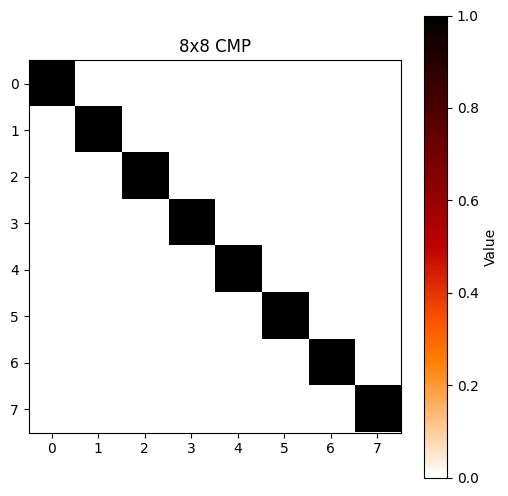

[[0.000e+000 1.000e+000 0.000e+000 0.000e+000 0.000e+000 0.000e+000
  0.000e+000 0.000e+000]
 [0.000e+000 1.000e+000 0.000e+000 5.908e-226 0.000e+000 0.000e+000
  0.000e+000 0.000e+000]
 [0.000e+000 1.000e+000 0.000e+000 0.000e+000 0.000e+000 0.000e+000
  0.000e+000 0.000e+000]]


np.float64(6.0)

In [48]:
test_CPM = CPM('perfect', M, P, 0.1)
print(weighted_avg(log_loss, test_CPM, P))
test_CPM.colored_plot(test_CPM.CPM)
X = test_CPM.dirichlet_sample(1, delta=100, size=3)
print(X)
np.sum([brier_score(x,0) for x in X])

In [61]:
# This part compares how the metrics would with different classifiers
types_n_params = {'noisy_low': 4,
                  'noisy_high': 0.1,
                  #'subs_perfect': [M-1, 2, 1, 0, 10],
                  'subs_low': [M-1, 2, 1, 0, 4],
                  'subs_high': [M-1, 2, 1, 0, 0.1],
                  #'mutuallysubs_perfect': [M-1, 2, 1, 0, 10],
                  'mutuallysubs_low': [M-1, 2, 1, 0, 4],
                  'mutuallysubs_high': [M-1, 2, 1, 0, 0.1],
                  'cruise': [M-1, 0.002],
                  'noisy_uncertain': 0}
print(np.max(P)/np.min(P))

1682.6838830166412


[2.421e+03 7.024e+01 4.458e+01 4.273e+01 2.177e+01 1.182e+01 8.789e+00
 1.439e+00]
[   2.      35.459   55.294   57.651  112.199  205.855  276.421 1683.684]
[1.846 0.95  0.94  0.939 0.932 0.928 0.927 0.924]


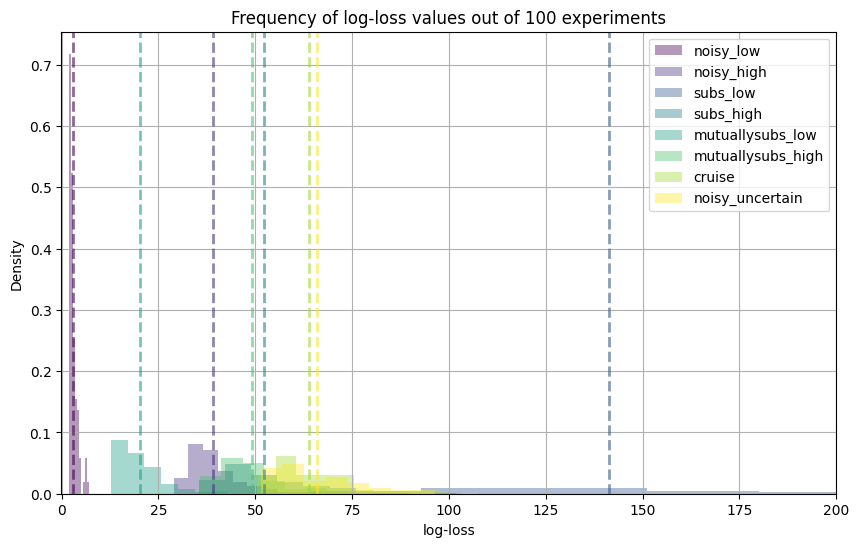

In [63]:
ITER_SIZE = 100
WEIGHTS = 1/P
func = log_loss
print(WEIGHTS)
print(1 + ((1/np.min(P))*P))
print((1 + ((1/np.min(P))*P))*WEIGHTS/np.sum(WEIGHTS))

all_data = []
for key in types_n_params:
    details = key.split('_')
    params = types_n_params[key]
    baseline_cpm = CPM(details[0], M, P, params)
    metric_loss_sample = []
    for k in range(ITER_SIZE):
        metric_loss = 0
        # Generates samples
        for i in range(M):
            samples = baseline_cpm.dirichlet_sample(i, delta=1,
                                                    size=1 + int((1/np.min(P))*P[i]))
            metric_loss += WEIGHTS[i]*np.sum([func(x, i) for x in samples])

        metric_loss_sample.append(metric_loss/np.sum(WEIGHTS))
    all_data.append(np.array(metric_loss_sample))

plt.figure(figsize=(10, 6))
keys = list(types_n_params.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))
for i, sample in enumerate(all_data):
    plt.hist(sample, bins=10, alpha=0.4, label=f'{keys[i]}', color=colors[i], density=True)
    plt.axvline(np.mean(sample), alpha=0.6, color=colors[i], linestyle='--', linewidth=2)

plt.xlim(left=-0.1, right=200)
plt.title(f'Frequency of log-loss values out of {ITER_SIZE} experiments')
plt.xlabel('log-loss')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
np.mean(all_data, axis=1)
U = np.random.uniform(0,1,5)
print(U)
(U - (U == U[0]))**2

[0.442 0.858 0.94  0.147 0.829]


array([0.311, 0.736, 0.883, 0.022, 0.687])